In [25]:
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation 
from sklearn import metrics
from sklearn import grid_search
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# This is a function used for computing the missing rate of each variable, can only handle missing value is NaN
# We can also use a simpler form to do acheive this result DF.count() / DF.shape[0]
def computeVariableMissingRate(Var):
    return len(Var[Var.isnull()]) / len(Var)

#Find the value which has the largest frequecy in a Series
def findHighestCountValue(SSeries):
    return SSeries.value_counts().index[0]

fontdict = {'fontsize': 18,
        'fontweight' : 1,
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}

def output_kaggle_csv(prediction, output_name):
    submission = pd.DataFrame({"PassengerId": test['passengerid'], "Survived": prediction})
    submission.to_csv(output_name, index=False)

In [78]:
pd.DataFrame.to_csv?

# Load Data

In [26]:
test = pd.read_csv("./input/test.csv")
train = pd.read_csv("./input/train.csv")

# 1 - Data Exploration

## 1.1 - Lowercase all columns' names

In [27]:
test.columns = (test.columns).str.lower()
train.columns = (train.columns).str.lower()

In [28]:
test.head(3)

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [29]:
train.head(3)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 1.2 - Delete uesless variables

In [30]:
train_useful = train.drop(['name', 'ticket', 'passengerid'], axis=1)
test_useful = test.drop(['name', 'ticket', 'passengerid'], axis=1)

In [31]:
train_useful.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S


In [32]:
test_useful.head(3)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q


In [33]:
# Explore the data type and number of non-missing values of each variable
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
passengerid    891 non-null int64
survived       891 non-null int64
pclass         891 non-null int64
name           891 non-null object
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
ticket         891 non-null object
fare           891 non-null float64
cabin          204 non-null object
embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [34]:
# Explore the missing rate of each variable
# These three are useful also, but not that simpler
# print(train.apply(computeVariableMissingRate, axis=0))
# print ('\n----------------\n')
# print(test.apply(computeVariableMissingRate, axis=0))


print(train_useful.count() / train.shape[0])
print ('\n----------------\n')
print(test_useful.count() / test.shape[0])

survived    1.000000
pclass      1.000000
sex         1.000000
age         0.801347
sibsp       1.000000
parch       1.000000
fare        1.000000
cabin       0.228956
embarked    0.997755
dtype: float64

----------------

pclass      1.000000
sex         1.000000
age         0.794258
sibsp       1.000000
parch       1.000000
fare        0.997608
cabin       0.217703
embarked    1.000000
dtype: float64


## 1.3 - Delete variables that have too many missing values and impute others have missing values

### 1.3.1 - Drop 'cabin'

In [35]:
# I have not take the drop action on origin data, this is not suggested on big data set
train_dropt = train_useful.drop('cabin', axis=1)
test_dropt = test_useful.drop('cabin', axis=1)

In [36]:
#see whether the drop function has effect
train_dropt.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [37]:
#see whether the drop function has effect
test_dropt.head(3)

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q


### 1.3.2 - Impute 'embark', 'fare' and 'age'

In [38]:
train_dropt_imputed = train_dropt.copy()
test_dropt_imputed = test_dropt.copy()

train_dropt_imputed['embarked'].fillna(findHighestCountValue(train_dropt_imputed['embarked']), inplace=True)
train_dropt_imputed['age'].fillna(train_dropt_imputed['age'].mean(), inplace=True)


test_dropt_imputed['embarked'].fillna(findHighestCountValue(test_dropt_imputed['embarked']), inplace=True)
test_dropt_imputed['age'].fillna(test_dropt_imputed['age'].mean(), inplace=True)
test_dropt_imputed['fare'].fillna(test_dropt_imputed['fare'].mean(), inplace=True)

In [39]:
print(train_dropt_imputed.count() / train_dropt_imputed.shape[0])
print ('\n----------------\n')
print(test_dropt_imputed.count() / test_dropt_imputed.shape[0])

survived    1.0
pclass      1.0
sex         1.0
age         1.0
sibsp       1.0
parch       1.0
fare        1.0
embarked    1.0
dtype: float64

----------------

pclass      1.0
sex         1.0
age         1.0
sibsp       1.0
parch       1.0
fare        1.0
embarked    1.0
dtype: float64


# 2 - Feature Engineering

In [40]:
train_dropt_imputed.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')

### 2.1 - variable 'pclass'
#### Pclass is a proxy for socio-economic status (SES) <font color='red'>1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower</font>

In [41]:
train_dropt_imputed['pclass'].value_counts()

3    491
1    216
2    184
Name: pclass, dtype: int64

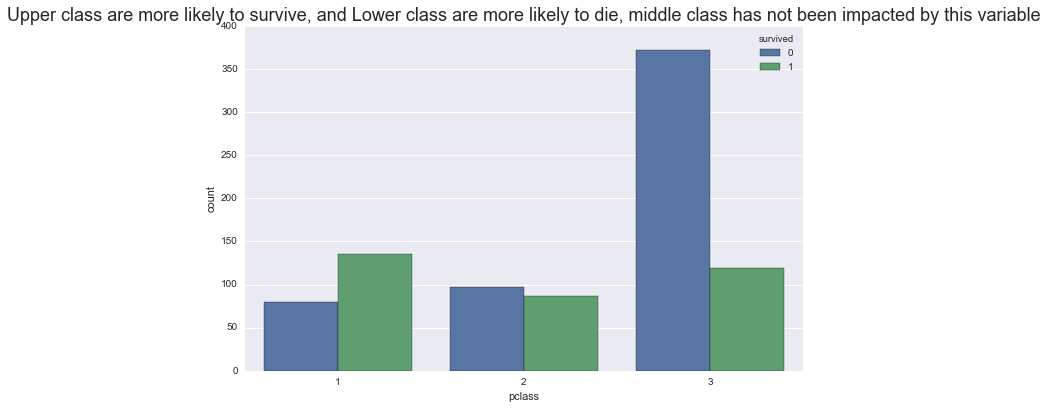

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6.18))
sns.countplot(x='pclass', hue='survived', data=train_dropt_imputed, ax=ax)

ax.set_title('Upper class are more likely to survive, and Lower class are more likely to die, \
middle class has not been impacted by this variable', fontdict=fontdict)

In [43]:
train_plcass_dummy = pd.get_dummies(train_dropt_imputed['pclass'])
train_plcass_dummy.columns = ['pclass_1', 'pclass_2', 'pclass_3']
train_dropt_imputed_dummy1 = pd.concat([train_dropt_imputed, train_plcass_dummy], axis=1)

test_plcass_dummy = pd.get_dummies(test_dropt_imputed['pclass'])
test_plcass_dummy.columns = ['pclass_1', 'pclass_2', 'pclass_3']
test_dropt_imputed_dummy1 = pd.concat([test_dropt_imputed, test_plcass_dummy], axis=1)

### 2.2 - variable 'sex'

In [44]:
train_dropt_imputed_dummy1['sex'].value_counts()

male      577
female    314
Name: sex, dtype: int64

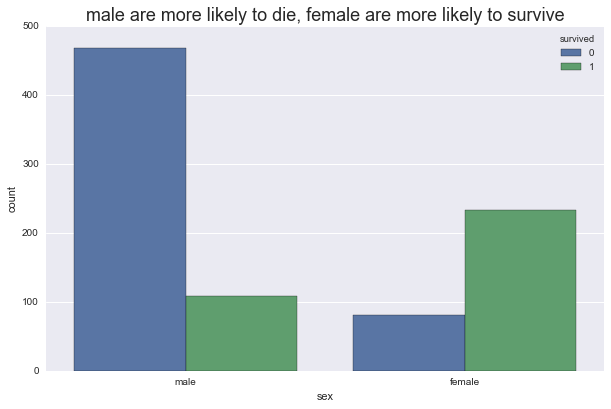

In [45]:
fig, (ax) = plt.subplots(1, 1, figsize=(10, 6.18))
sns.countplot(x='sex', hue='survived', data=train_dropt_imputed_dummy1, ax=ax)
ax.set_title('male are more likely to die, female are more likely to survive', fontdict=fontdict)

In [46]:
train_dropt_imputed_dummy1['sex'][train_dropt_imputed_dummy1['sex'] == 'male'] = 1
train_dropt_imputed_dummy1['sex'][train_dropt_imputed_dummy1['sex'] == 'female'] = 0 

test_dropt_imputed_dummy1['sex'][test_dropt_imputed_dummy1['sex'] == 'male'] = 1 
test_dropt_imputed_dummy1['sex'][test_dropt_imputed_dummy1['sex'] == 'female'] = 0 

C:\Users\cyi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\cyi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\cyi\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\cyi\AppDa

In [47]:
train_dropt_imputed_dummy1.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,pclass_1,pclass_2,pclass_3
0,0,3,1,22.0,1,0,7.2500,S,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,C,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,S,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,S,1.0,0.0,0.0
4,0,3,1,35.0,0,0,8.0500,S,0.0,0.0,1.0


### 2.3 - variable 'age'
Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

In [48]:
# round age, easy to fit tree
train_dropt_imputed_dummy1['age'] = train_dropt_imputed_dummy1['age'].round().astype(int)
test_dropt_imputed_dummy1['age'] = test_dropt_imputed_dummy1['age'].round().astype(int)

C:\Users\cyi\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


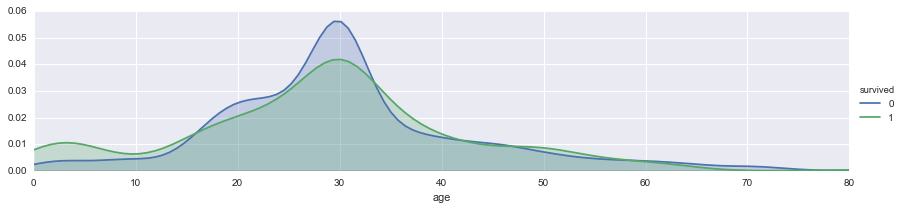

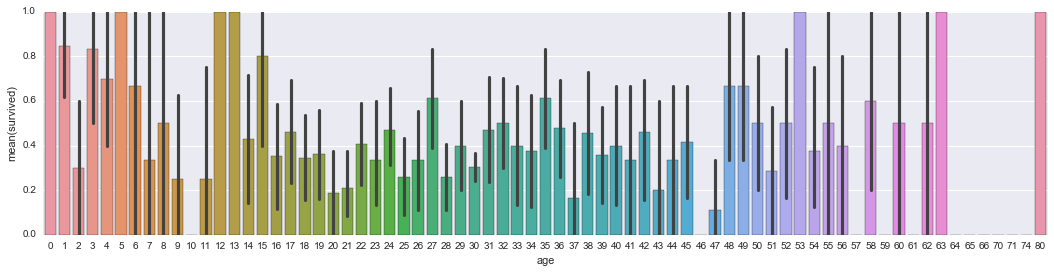

In [49]:
facet = sns.FacetGrid(train_dropt_imputed_dummy1, hue='survived', aspect=4)
facet.map(sns.kdeplot, 'age', shade=True)
facet.add_legend()
facet.set(xlim=(0, train_dropt_imputed_dummy1['age'].max()))


# If people are two old or young, they have a higher probability to survive
fig, ax = plt.subplots(1,1, figsize=(18,4))
sns.barplot(x='age', y='survived', data=train_dropt_imputed_dummy1)

### variable 'sibsp' & 'parch'
Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic  
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)  
Parent:   Mother or Father of Passenger Aboard Titanic  
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic  
  
Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws.  Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

### variable 'fare'  
Passenger Fare

In [50]:
train_dropt_imputed_dummy1['fare'] = train_dropt_imputed_dummy1['fare'].round().astype(int)
test_dropt_imputed_dummy1['fare'] = test_dropt_imputed_dummy1['fare'].round().astype(int)

C:\Users\cyi\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


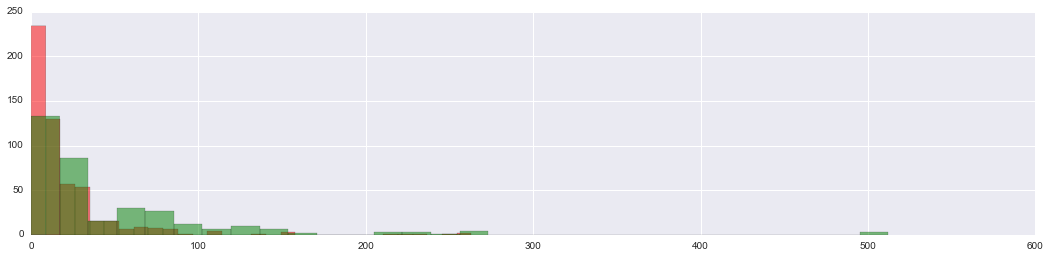

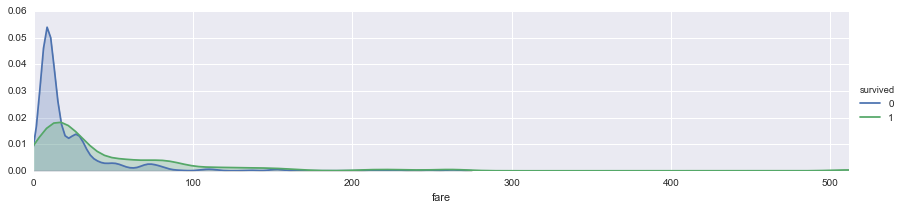

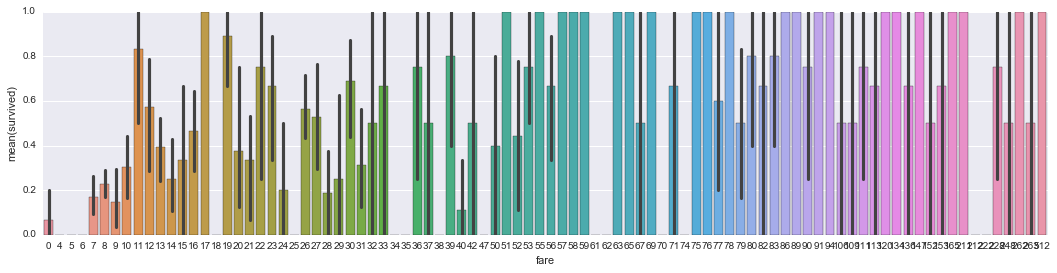

In [51]:
fig, ax = plt.subplots(1,1, figsize=(18,4))
ax.hist(train_dropt_imputed_dummy1[train_dropt_imputed_dummy1['survived'] == 0]['fare'], color='red', bins=30, alpha=0.5)
ax.hist(train_dropt_imputed_dummy1[train_dropt_imputed_dummy1['survived'] == 1]['fare'], color='green', bins=30, alpha=0.5)

facet = sns.FacetGrid(train_dropt_imputed_dummy1, hue='survived', aspect=4)
facet.map(sns.kdeplot, 'fare', shade=True)
facet.add_legend()
facet.set(xlim=(0, train_dropt_imputed_dummy1['fare'].max()))


# rich people seldom die, a lot of people buy a cheap ticket
fig, ax = plt.subplots(1,1, figsize=(18,4))
sns.barplot(x='fare', y='survived', data=train_dropt_imputed_dummy1)

### variable 'embark'

In [52]:
train_dropt_imputed_dummy1['embarked'].value_counts()

S    646
C    168
Q     77
Name: embarked, dtype: int64

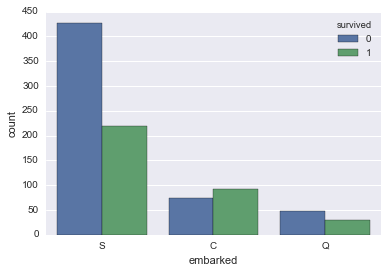

In [53]:
# people get on board from S and Q are more likely to die, the opposite in C 
sns.countplot(x='embarked', hue='survived', data=train_dropt_imputed_dummy1)

In [54]:
train_embark_dummy = pd.get_dummies(train_dropt_imputed_dummy1['embarked'])
train_embark_dummy.columns = ['embark_c', 'embark_q', 'embark_s']
train_dropt_imputed_dummy2 = pd.concat([train_dropt_imputed_dummy1, train_embark_dummy], axis=1)


test_embark_dummy = pd.get_dummies(test_dropt_imputed_dummy1['embarked'])
test_embark_dummy.columns = ['embark_c', 'embark_q', 'embark_s']
test_dropt_imputed_dummy2 = pd.concat([test_dropt_imputed_dummy1, test_embark_dummy], axis=1)

In [55]:
train_dropt_imputed_dummy2.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,pclass_1,pclass_2,pclass_3,embark_c,embark_q,embark_s
0,0,3,1,22,1,0,7,S,0.0,0.0,1.0,0.0,0.0,1.0
1,1,1,0,38,1,0,71,C,1.0,0.0,0.0,1.0,0.0,0.0
2,1,3,0,26,0,0,8,S,0.0,0.0,1.0,0.0,0.0,1.0


In [56]:
train_final = train_dropt_imputed_dummy2.drop(['pclass', 'embarked'], axis=1)
test_final = test_dropt_imputed_dummy2.drop(['pclass', 'embarked'], axis=1)

In [57]:
train_final.head()

,survived,sex,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,embark_c,embark_q,embark_s
0,0,1,22,1,0,7,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0,38,1,0,71,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0,26,0,0,8,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,35,1,0,53,1.0,0.0,0.0,0.0,0.0,1.0
4,0,1,35,0,0,8,0.0,0.0,1.0,0.0,0.0,1.0


In [58]:
test_final.head()

,sex,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,embark_c,embark_q,embark_s
0,1,34,0,0,8,0.0,0.0,1.0,0.0,1.0,0.0
1,0,47,1,0,7,0.0,0.0,1.0,0.0,0.0,1.0
2,1,62,0,0,10,0.0,1.0,0.0,0.0,1.0,0.0
3,1,27,0,0,9,0.0,0.0,1.0,0.0,0.0,1.0
4,0,22,1,1,12,0.0,0.0,1.0,0.0,0.0,1.0


# Modeling - Do not run until Croos validation 

In [ ]:
# %timeit train_final.drop('survived', axis=1)
# %timeit train_final.iloc[:, train_final.columns != 'survived'] #this is a little faster than the one above


train_final_y = train_final['survived'].values
train_final_x = train_final.values[0::,1::]

rf = RandomForestClassifier(random_state=0)

#### Explore importance of each variable

In [ ]:
[{x : y} for (x, y) in zip(train_final.drop('survived', axis=1).columns, rf.feature_importances_)]

#### Explore accuracy on the given test data and labels.

In [ ]:
print (rf.score(train_final_x, train_final_y))

#### Explore confusion metrix and precision recall

[precision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

In [ ]:
metrics.confusion_matrix(train_final_y, rf.predict(train_final_x))

In [ ]:
metrics.precision_score(train_final_y, rf.predict(train_final_x))

In [ ]:
metrics.recall_score(train_final_y, rf.predict(train_final_x))

#### Cross Validation

In [577]:
cross_validation.cross_val_score(rf, train_final_x, train_final_y, cv=5, verbose=3)

[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.798883 -   0.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.782123 -   0.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.842697 -   0.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.786517 -   0.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.824859 -   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


array([ 0.79888268,  0.78212291,  0.84269663,  0.78651685,  0.82485876])

# Create datasets

In [ ]:
train_final_y = train_final['survived']
train_final_x = train_final.drop('survived', axis=1)

#### GridSearch to find the best parameters

In [75]:
rf = RandomForestClassifier()
grid_search_params = {'criterion': ['gini', 'entropy'], 'n_estimators':[40,60,80,100], 'max_depth': np.arange(2,11,2), 'min_samples_split':np.arange(8,17,2), 'random_state':[0, 100, 999]}

In [76]:
gs = grid_search.GridSearchCV(rf, grid_search_params, cv=10, refit=True)
gs.fit(train_final_x, train_final_y)
print (gs.best_params_)
print (gs.best_score_)
rf_estimator = gs.best_estimator_
rf_submission = rf_estimator.predict(test_final)
print(rf_estimator.score(train_final_x, train_final_y))

{'n_estimators': 60, 'min_samples_split': 8, 'criterion': 'entropy', 'random_state': 100, 'max_depth': 8}
0.832772166105
0.875420875421


In [79]:
output_kaggle_csv(rf_submission, 'Adjusted_RF.csv')